In [1]:
import os
from os.path import isfile, isdir, join
import logging
import shutil

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily
import itertools

import crime_patterns.utilities as utils
import crime_patterns.config as config
import crime_patterns.data_management as dm

%load_ext autoreload
%autoreload 2

In [2]:
logger = logging.getLogger(__name__)
# logger.setLevel(logging.INFO)

In [11]:
data_dir = r"..\crime_patterns\data"
shapefiles_dir = os.path.join(data_dir, "statistical-gis-boundaries-london", "statistical-gis-boundaries-london", "ESRI")
london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
london_LSOA_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")

# crime_incidence_path = os.path.join(data_dir, r"uk_crime_data_all\2021-01\2021-01-city-of-london-street.csv")
crime_incidence_dir = os.path.join(data_dir, r"uk_crime_data_2019", "2019-12") #\2021-01\2021-01-city-of-london-street.csv")
mps_lsoa_crime_path = os.path.join(data_dir, r"MPS_LSOA_Level_Crime\MPS LSOA Level Crime (Historical).csv")
cleaned_data_dir = r"C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\bld\python\data"

In [4]:
# My area of interest was London as this is where I live. 
# The Greater London area is covered by the Metropolitan Police Service and the City of London Police data sets. 
# I chose 2016 as the study period and downloaded the monthly data sets.

# (I only realized at a later stage when plotting the data that the Metropolitan Police Service data included crimes from other cities in the UK. 
# This was easily corrected by including an extra step in my data preparation phase outlined in the next step.)

In [5]:
year = "2019" # ["%.2d" % i for i in np.arange(2020, 2023, 1)]
months = ["%.2d" % i for i in np.arange(1, 13, 1)]

In [7]:
src = config.SRC
bld = config.BLD
data_info = utils.read_yaml(src / "data_management" / "data_info.yaml")

In [8]:
data_info

{'crime_year': '2019',
 'crime_type': 'Burglary',
 'urls': {'uk_crime_data_2019': 'https://data.police.uk/data/archive/2019-12.zip',
  'imd_lsoa': 'https://opendatacommunities.org/downloads/cube-table?uri=http%3A%2F%2Fopendatacommunities.org%2Fdata%2Fsocietal-wellbeing%2Fimd2019%2Findices',
  'imd_lsoa_shp': 'https://www.arcgis.com/sharing/rest/content/items/5e1c399d787e48c0902e5fe4fc1ccfe3/data',
  'statistical_gis_boundaries_london': 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip',
  'lsoa_level_crime': 'https://data.london.gov.uk/download/recorded_crime_summary/9bb3efe6-98fb-47c1-af3e-3be721e8a1cd/MPS%20LSOA%20Level%20Crime%20%28Historical%29.csv'},
 'data_raw_dirs': {'uk_crime_data_2019': 'uk_crime_data_2019',
  'statistical_gis_boundaries_london': 'statistical-gis-boundaries-london',
  'lsoa_level_crime': 'MPS_LSOA_Level_Crime',
  'imd_lsoa': 'IMD_LSOA_2019',
  'imd_lsoa_shp': 'I

In [12]:
london_lsoa = gpd.read_file(london_LSOA_shp_path)
london_ward = gpd.read_file(london_ward_shp_path)
london_borough = gpd.read_file(london_borough_shp_path)

In [14]:
london_ward["dissolve_key"] = "dissolve"
london_ward_dissolved = london_ward.dissolve(by="dissolve_key")
london_ward_dissolved.loc[:, "NAME"]  = "Greater London Area"

<Axes: >

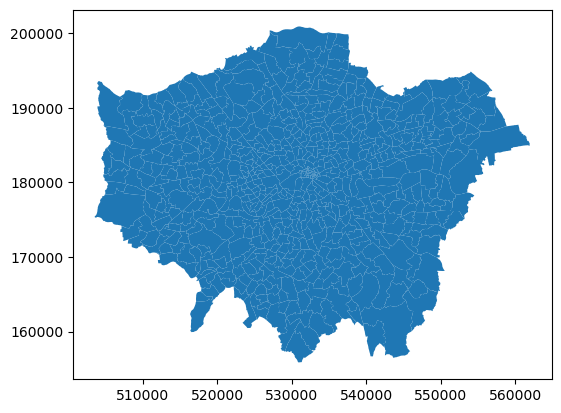

In [26]:
london_ward.plot()

<Axes: >

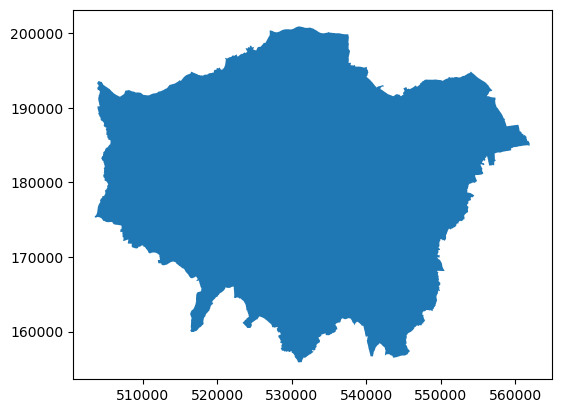

In [27]:
london_ward_dissolved.plot()

In [25]:
london_ward_dissolved[["geometry", "NAME"]].to_file("")

,geometry,NAME
dissolve_key,,
dissolve,"POLYGON ((517066.300 167341.100, 517047.500 16...",Greater London Area


TypeError: cannot unpack non-iterable Axes object

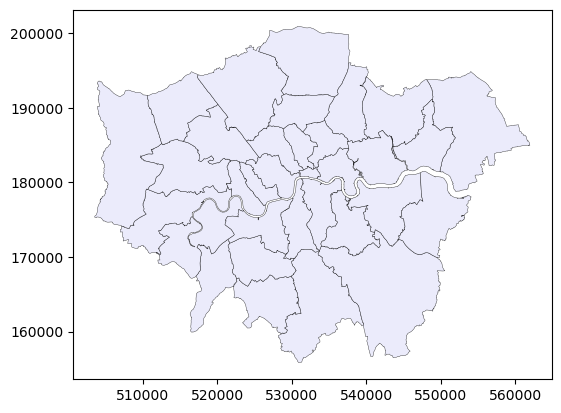

In [39]:
fig, axes = london_borough.plot(color="lavender", edgecolor="black", linewidth= 0.3, alpha=0.8)

# contextily.add_basemap(
#     axes,
#     crs=london_ward.crs,
#     source=contextily.providers.CartoDB.PositronNoLabels,
# )

In [39]:
london_ward.crs

<Derived Projected CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [41]:
# london_ward_4326 = london_ward.to_crs(4326)
crime_data_gdf_BritishGrid = crime_data_monthly_gdf.to_crs(london_ward.crs)

In [43]:
crime_data_gdf_BritishGrid.head()

,Month,Reported by,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,geometry
0,2019-01,City of London Police,-0.112422,51.515381,On or near Star Yard,E01000914,Camden 028B,Anti-social behaviour,POINT (531071.248 181294.792)
1,2019-01,City of London Police,-0.112422,51.515381,On or near Star Yard,E01000914,Camden 028B,Bicycle theft,POINT (531071.248 181294.792)
2,2019-01,City of London Police,-0.111497,51.518226,On or near Pedestrian Subway,E01000914,Camden 028B,Other theft,POINT (531127.259 181612.813)
3,2019-01,City of London Police,-0.097601,51.520699,On or near Carthusian Street,E01000001,City of London 001A,Anti-social behaviour,POINT (532084.176 181912.783)
4,2019-01,City of London Police,-0.095914,51.520348,On or near Beech Street,E01000001,City of London 001A,Anti-social behaviour,POINT (532202.225 181876.798)


In [53]:
london_city_mask_extent_mask = ((crime_data_gdf_BritishGrid["Longitude"] > -0.53) & (crime_data_gdf_BritishGrid["Longitude"] < 0.35) & (crime_data_gdf_BritishGrid["Latitude"] > 51.275) & (crime_data_gdf_BritishGrid["Latitude"] < 51.7))

In [54]:
clean_monthly_crime_data

In [57]:
crime_data_gdf_BritishGrid_masked_burglary = crime_data_gdf_BritishGrid_masked.query("`Crime type` == 'Burglary'")

<Axes: >

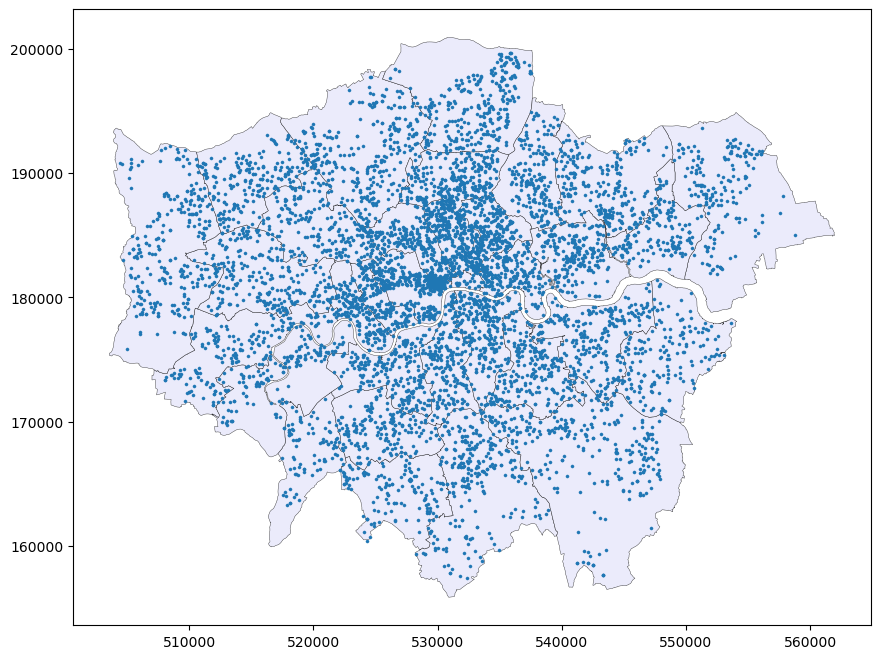

In [58]:
fig, ax = plt.subplots(figsize=(12,8))

london_borough.plot(ax=ax, color="lavender", edgecolor="black", linewidth= 0.3, alpha=0.8)

crime_data_gdf_BritishGrid_masked_burglary.plot(ax=ax, 
                    # color="red",
                    # cmap="Spectral",
                    # column='Crime type',
                    # colorbar=True,
                    markersize=5, 
                    # edgecolor="k", 
                    legend=True,
                    legend_kwds={'bbox_to_anchor': (0.5, 0.8)},
                    linewidth=0.3,
                    aspect=1
                    )

# ax.set_xlim(-0.150, -0.02)
# ax.set_ylim(51.49, 51.56)
# ax.legend()

In [39]:
crime_incidence_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
crime_incidence_gdf['Crime type'].unique()

array(['Anti-social behaviour', 'Other theft', 'Shoplifting',
       'Theft from the person', 'Criminal damage and arson', 'Drugs',
       'Public order', 'Violence and sexual offences', 'Bicycle theft',
       'Burglary', 'Vehicle crime', 'Robbery', 'Other crime',
       'Possession of weapons'], dtype=object)

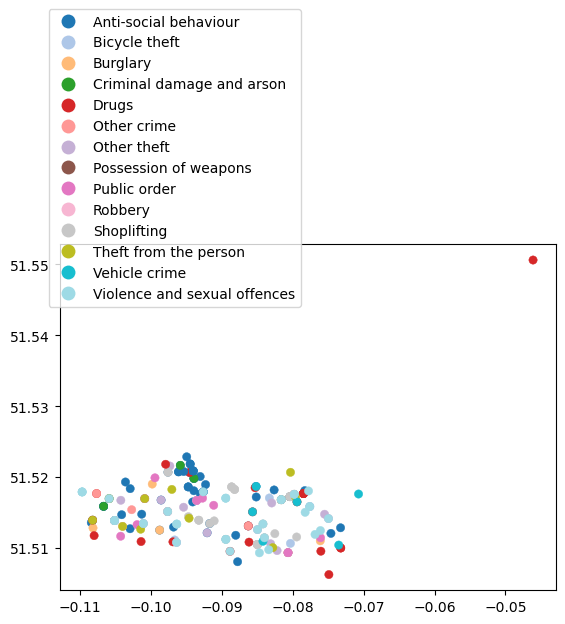

In [82]:
ax = crime_incidence_gdf.plot(# ax=ax, 
                        # color="red",
                        cmap="tab20",
                        column='Crime type',
                        # colorbar=True,
                        # markersize=2, 
                        # edgecolor="k", 
                        legend=True,
                        legend_kwds={'bbox_to_anchor': (0.5, 0.8)},
                        linewidth=0.3,
                        aspect=1
                        )
                        
